In [1]:
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy
import librosa
import librosa.core
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense


import torch
import torch.nn as nn
from asteroid.models import XUMXControl
import museval

In [2]:
#set machine and id
MACHINE = 'valve'
S1 = 'id_00'
S2 = 'id_02'
model_path = '/hdd/hdd1/lyj/xumx/output_w_cont_valve2/checkpoints/epoch=998-step=44954.ckpt'
#model_path = '/hdd/hdd1/lyj/xumx/output_w_cont_valve2/checkpoints/epoch=998-step=44954.ckpt'

# choose wave file and status
wav_num1 = "00000001"
wav_num2 = "00000010"
status_s1 = "abnormal"
status_s2 = "normal"

In [3]:
# load weight of AE 
#TODO ###################
ae_path = '/hdd/hdd1/lyj/xumx/ae/cont/valve/shared_ae/id_00_02/shared_ae3.pth'
#ae_path = '/hdd/hdd1/lyj/xumx/ae/cont/valve/shared_ae/id_00_02/shared_ae3.pth'

# set source path 
source1_path = "/dev/shm/mimii/6dB/{machine}/{source}/{status}/{num}.wav".format(machine = MACHINE, source = S1, status= status_s1, num = wav_num1)
source2_path = "/dev/shm/mimii/6dB/{machine}/{source}/{status}/{num}.wav".format(machine = MACHINE, source = S2, status = status_s2, num = wav_num2)

machine_types = [S1, S2]
source_path = [source1_path, source2_path]

threshold_lst = []
num_eval_normal = 250

In [4]:
# pickle I/O
def save_pickle(filename, save_data):
    with open(filename, 'wb') as sf:
        pickle.dump(save_data, sf)


def load_pickle(filename):
    with open(filename, 'rb') as lf:
        load_data = pickle.load(lf)
    return load_data


# wav file Input
def file_load(wav_name, mono=False):
    return librosa.load(wav_name, sr=None, mono=mono)
        


def demux_wav(wav_name, channel=1):
   
    multi_channel_data, sr = file_load(wav_name)
    if multi_channel_data.ndim <= 1:
        return sr, multi_channel_data

    return sr, numpy.array(multi_channel_data)[:channel, :]


########################################################################
# feature extractor
########################################################################

def file_to_wav(file_name):
    sr, y = demux_wav(file_name, channel=2)
    return sr, y

def wav_to_vector_array(sr, y,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.
    file_name : str
        target .wav file
    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray


def bandwidth_to_max_bin(rate, n_fft, bandwidth):
    freqs = numpy.linspace(0, float(rate) / 2, n_fft // 2 + 1, endpoint=True)

    return numpy.max(numpy.where(freqs <= bandwidth)[0]) + 1


class XUMXSystem(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = None


def xumx_model(path):
    
    x_unmix = XUMXControl(
        window_length=4096,
        input_mean=None,
        input_scale=None,
        nb_channels=2,
        hidden_size=512,
        in_chan=4096,
        n_hop=1024,
        sources=[S1, S2],
        max_bin=bandwidth_to_max_bin(16000, 4096, 16000),
        bidirectional=True,
        sample_rate=16000,
        spec_power=1,
        return_time_signals=True,
    )

    conf = torch.load(path, map_location="cpu")

    system = XUMXSystem()
    system.model = x_unmix

    system.load_state_dict(conf['state_dict'], strict=False)

    return system.model


machine_types = [S1, S2]
num_eval_normal = 250


def train_list_to_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0,
                         target_source=None):
    
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in tqdm(range(len(file_list)), desc=msg):
        active_label_sources = {}
        mixture_y = 0
        target_type = os.path.split(os.path.split(os.path.split(file_list[idx])[0])[0])[1]
        if target_source is not None:
            target_idx = machine_types.index(target_source)
        else:
            target_idx = machine_types.index(target_type)
        for machine in machine_types:
            filename = file_list[idx].replace(target_type, machine)
            sr, y = file_to_wav(filename)
            ##############################################################
            #generate control signal 
            label = generate_label(y)
            active_label_sources[machine] = label
            ##############################################################
            mixture_y = mixture_y + y
            
        active_labels = torch.stack([active_label_sources[src] for src in machine_types])
        _, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
        
        # [src, b, ch, time]
        ys = time[target_idx, 0, 0, :].detach().cpu().numpy()
        
        vector_array = wav_to_vector_array(sr, ys,
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return dataset


class AEDataset(torch.utils.data.Dataset):
    def __init__(self, 
            sep_model, 
            file_list,
            param,
            target_source=None,
            ):
        self.sep_model = sep_model
        self.file_list = file_list
        self.target_source = target_source

        self.data_vector = train_list_to_vector_array(self.file_list,
                                            msg="generate train_dataset",
                                            n_mels=param["feature"]["n_mels"],
                                            frames=param["feature"]["frames"],
                                            n_fft=param["feature"]["n_fft"],
                                            hop_length=param["feature"]["hop_length"],
                                            power=param["feature"]["power"],
                                            target_source=target_source)
        
    
    def __getitem__(self, index):
        return torch.Tensor(self.data_vector[index, :])
    
    def __len__(self):
        return self.data_vector.shape[0]


def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                ext=ext))))
    normal_len = [len(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir.replace(S1, mt),
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext)))) for mt in machine_types]   #dataset 중에서 가장 짧은 것 기준
    normal_len = min(min(normal_len), len(normal_files))
    normal_files = normal_files[:normal_len]


    normal_labels = numpy.zeros(len(normal_files))

    # 02 abnormal list generate
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))
    abnormal_files.extend(sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir.replace(S1, S2),
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                 ext=ext)))))                                               
    abnormal_labels = numpy.ones(len(abnormal_files))

    # 03 separate train & eval
    train_files = normal_files[num_eval_normal:]
    train_labels = normal_labels[num_eval_normal:]
    eval_normal_files = sum([[fan_file.replace(S1, machine_type) for fan_file in normal_files[:num_eval_normal]] for machine_type in machine_types], [])
    eval_files = numpy.concatenate((eval_normal_files, abnormal_files), axis=0)
    eval_labels = numpy.concatenate((normal_labels[:num_eval_normal], normal_labels[:num_eval_normal], abnormal_labels), axis=0)  ##TODO 

    return train_files, train_labels, eval_files, eval_labels


def dataset_generator_new_anomaly(target_dir, machine_types,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):

    # 01 normal list generate for source 2 
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                ext=ext))))

    normal_labels = numpy.zeros(len(normal_files))

    # 02 abnormal list generate for source 1
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir.replace(S2, machine_types[0]),
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))
    
    
    file_len = min(len(normal_files), len(abnormal_files))
    normal_files = normal_files[:file_len]

    abnormal_labels = numpy.ones(file_len)
                            
    # 03 separate train & eval
    eval_normal_files = normal_files[:file_len]
    eval_labels = abnormal_labels[:file_len]

    return eval_normal_files, eval_labels



########################################################################
# keras model
########################################################################
def keras_model(inputDim):
    """
    define the keras model
    the model based on the simple dense auto encoder (64*64*8*64*64)
    """
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    h = Dense(8, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(inputDim, activation=None)(h)

    return Model(inputs=inputLayer, outputs=h)

class TorchModel(nn.Module):
    def __init__(self, dim_input):
        super(TorchModel,self).__init__()
        self.ff = nn.Sequential(
            nn.Linear(dim_input, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
            nn.ReLU(),
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, dim_input),
        )

    def forward(self, x):
        x = self.ff(x)
        return x
    
    def forward_latent(self, x):
        for i, module in enumerate(self.ff):
            x = module(x)
            if i == 5:
                l = x
        return x, l


def generate_label(y):
    rms_fig = librosa.feature.rms(y)
    rms_tensor = torch.tensor(rms_fig).reshape(1, -1, 1)
    rms_trim = rms_tensor.expand(-1, -1, 512).reshape(1, -1)[:, :160000]

    if MACHINE == 'valve':
        k = int(y.shape[1]*0.8)
        min_threshold, _ = torch.kthvalue(rms_trim, k)
    else:
        min_threshold = (torch.max(rms_trim) + torch.min(rms_trim))/2
    label = (rms_trim > min_threshold).type(torch.float)
    label = label.expand(y.shape[0], -1)
    return label
########################################################################


In [5]:
# Load separation model
sep_model = xumx_model(model_path)
sep_model.eval()
sep_model = sep_model.cuda()

In [6]:
with open("baseline.yaml") as stream:
    param = yaml.safe_load(stream)
train_files, train_labels, eval_files, eval_labels = dataset_generator("/dev/shm/mimii/6dB/{machine}/{source}".format(machine = MACHINE, source = S1))
dim_input = 320

In [7]:
# load shared auto encoder
ae_model = TorchModel(dim_input)
checkpoint = torch.load(ae_path)
ae_model.load_state_dict(checkpoint)
ae_model.eval()
ae_model = ae_model.cuda()

In [8]:
# find best threshold
y_pred = numpy.array([0. for k in eval_labels])
y_true = numpy.array(eval_labels)

eval_types = {mt: [] for mt in machine_types}

latents = [None for k in eval_labels]

for num, file_name in tqdm(enumerate(eval_files), total=len(eval_files)):
    machine_type = os.path.split(os.path.split(os.path.split(file_name)[0])[0])[1]
    target_idx = machine_types.index(machine_type)  
    y_raw = {}
    mixture_y = 0
    active_label_sources = {}
    for normal_type in machine_types:
        if normal_type == machine_type:
            continue
        normal_file_name = file_name.replace(machine_type, normal_type).replace('abnormal', 'normal')
        sr, y = file_to_wav(normal_file_name)
        label = generate_label(y)
        active_label_sources[normal_type] = label
        mixture_y += y 
        y_raw[normal_type] = y

    sr, y = file_to_wav(file_name)
    label = generate_label(y)
    active_label_sources[machine_type] = label 
    mixture_y += y
    y_raw[machine_type] = y

    active_labels = torch.stack([active_label_sources[src] for src in machine_types])
    _, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
    # [src, b, ch, time]
    ys = time[target_idx, 0, 0, :].detach().cpu().numpy()

    data = wav_to_vector_array(sr, ys,
                                n_mels=param["feature"]["n_mels"],
                                frames=param["feature"]["frames"],
                                n_fft=param["feature"]["n_fft"],
                                hop_length=param["feature"]["hop_length"],
                                power=param["feature"]["power"])
    data = torch.Tensor(data).cuda()
    pred, latent = ae_model.forward_latent(data)
    error = torch.mean(((data - pred) ** 2), dim=1)

    y_pred[num] = torch.mean(error).detach().cpu().numpy()
    eval_types[machine_type].append(num)
    latents[num] = latent.detach().cpu().numpy()

for machine_type in machine_types:
    fpr, tpr,threshold = metrics.roc_curve(y_true[eval_types[machine_type]], y_pred[eval_types[machine_type]])
    score = metrics.roc_auc_score(y_true[eval_types[machine_type]], y_pred[eval_types[machine_type]])
    print("SCORE:", score)
    j = tpr-fpr
    idx = numpy.argmax(j)
    threshold_lst.append(numpy.array(threshold[idx]).astype('float'))
print(threshold_lst)


  0%|                                                                                       | 0/739 [00:00<?, ?it/s]/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.00039673  0.00027466 -0.00088501 ... -0.00192261 -0.00115967
   0.00115967]
 [-0.00146484 -0.00054932 -0.00039673 ... -0.00115967 -0.00073242
   0.        ]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 9.5184326e-02 -5.8105469e-02 -1.2997437e-01 ... -9.4604492e-04
  -1.5258789e-04  1.2207031e-04]
 [ 3.9093018e-02  1.6113281e-02 -6.1340332e-02 ...  3.0517578e-05
  -9.1552734e-05 -4.2724609e-04]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/torch/functional.py:655: UserWarning: istft will r

SCORE: 0.8065882352941176
SCORE: 0.6816
[array(14.77486324), array(12.46787071)]


In [9]:
from sklearn.manifold import TSNE

latent_shape = latents[0].shape
print(latent_shape)

latents = numpy.stack(latents)

latent_data = numpy.concatenate(latents[eval_types['id_00']], axis=0)


labels = []
for num, latent in enumerate(latents):
    normal = y_true[num] == 0
    label_len = latent.shape[0]
    machine_type = 'id_00' if num in eval_types['id_00'] else 'id_02'
    if machine_type == 'id_00':
        label = 0 if normal else 1
    else:
        continue
        label = 2 if normal else 3
    labels.append(numpy.array([label] * label_len))

label_data = numpy.concatenate(labels, axis=0)

# label_data[-100:] = numpy.array([3] * 100) ###





(309, 8)


In [10]:

unknown_filename = '/dev/shm/mimii/6dB/valve/id_04/abnormal/00000001.wav'

file_name = unknown_filename
machine_type = os.path.split(os.path.split(os.path.split(file_name)[0])[0])[1]
mixture_y = 0
active_label_sources = {}
for normal_type in ['id_04', 'id_02']:
    if normal_type == machine_type:
        sr, y = file_to_wav(file_name)
    else:
        normal_file_name = file_name.replace(machine_type, normal_type).replace('abnormal', 'normal')
        sr, y = file_to_wav(normal_file_name)
    label = generate_label(y)
    active_label_sources[normal_type] = label
    mixture_y += y 

active_labels = torch.stack([active_label_sources[src] for src in ['id_04', 'id_02']])
_, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
# [src, b, ch, time]
ys = time[0, 0, 0, :].detach().cpu().numpy()

data = wav_to_vector_array(sr, ys,
                            n_mels=param["feature"]["n_mels"],
                            frames=param["feature"]["frames"],
                            n_fft=param["feature"]["n_fft"],
                            hop_length=param["feature"]["hop_length"],
                            power=param["feature"]["power"])
data = torch.Tensor(data).cuda()
pred, latent = ae_model.forward_latent(data)

unknown_latents = latent.detach().cpu().numpy()
print(unknown_latents.shape)
unknown_labels = numpy.array([3] * unknown_latents.shape[0])

all_latents = numpy.concatenate([latent_data, unknown_latents], axis=0)

print(label_data.shape)
all_labels = numpy.concatenate([label_data, unknown_labels], axis=0)


/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[-0.00112915  0.00021362 -0.00054932 ...  0.00894165  0.0071106
   0.00582886]
 [-0.00012207  0.00054932  0.00021362 ...  0.00628662  0.00485229
   0.00619507]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.00091553  0.00085449  0.0007019  ... -0.00338745 -0.00253296
  -0.00097656]
 [ 0.00198364  0.00137329  0.00195312 ... -0.00259399 -0.00180054
  -0.00073242]] as keyword args. From version 0.10 passing these as positional arguments will result in an error


(309, 8)
(114021,)


In [11]:

tsne_model = TSNE(n_components=2, perplexity=50)
fit_latent = tsne_model.fit_transform(all_latents)
    

/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(114330, 2)
(114021,)


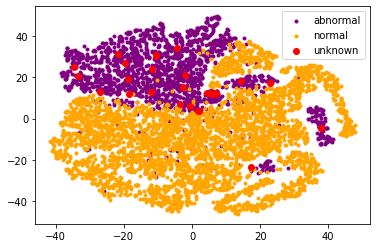

In [12]:
print(fit_latent.shape)
# label_data = numpy.concatenate(labels, axis=0)
print(label_data.shape)

# label_data[-100:] = numpy.array([4] * 100) ###

import matplotlib.pyplot as plt

plt.scatter(fit_latent[250 * 309:-309:20, 0], fit_latent[250 * 309:-309:20, 1], c='purple', marker=".", label="abnormal")
plt.scatter(fit_latent[:250 * 309:20, 0], fit_latent[:250 * 309:20, 1], c='orange', marker=".", label="normal")
plt.scatter(fit_latent[-309::10, 0], fit_latent[-309::10, 1], c='red', marker="o", label="unknown")

plt.legend()

In [13]:
# calculate accuracy based on best threshold
accuracy = {}
for idx, machine_type in enumerate(machine_types):
    threshold = threshold_lst[idx]
    threshold_ = threshold*numpy.ones(len(y_pred[eval_types[machine_type]]))
    y_pred_label = (y_pred[eval_types[machine_type]]>=threshold_).astype('float')
    score = sum(y_true[eval_types[machine_type]] == y_pred_label)
    accuracy[machine_type] = score/len(y_true[eval_types[machine_type]])
print(accuracy)

{'id_00': 0.8157181571815718, 'id_02': 0.6378378378378379}


In [14]:
# Set new anomaly source
new_anomaly_source = 'id_00'
anomaly_machine_type = [new_anomaly_source, S2]
eval_new_files, eval_new_labels = dataset_generator_new_anomaly("/dev/shm/mimii/6dB/{machine}/{source}".format(machine = MACHINE, source = S2), anomaly_machine_type)

In [15]:
# detect new anomaly sound
y_pred = numpy.array([0. for k in eval_new_labels])
sdr_pred_abnormal = {anomaly_machine_type[0]: []}

for num, file_name in tqdm(enumerate(eval_new_files), total=len(eval_new_files)):
    machine_type = os.path.split(os.path.split(os.path.split(file_name)[0])[0])[1]
    target_idx = machine_types.index(machine_type)  
    mixture_y = 0
    active_label_sources = {}
    y_raw = {}
    
    sr, y = file_to_wav(file_name)
    label = generate_label(y)
    active_label_sources[machine_type] = label
    y_raw[machine_type] = y
    mixture_y += y
    
    abnormal_file_name = file_name.replace(machine_type, anomaly_machine_type[0]).replace('normal', 'abnormal')
       
    sr, y = file_to_wav(abnormal_file_name)
    label = generate_label(y)
    active_label_sources[anomaly_machine_type[0]] = label 
    y_raw[anomaly_machine_type[0]] = y
    mixture_y += y
    

    active_labels = torch.stack([active_label_sources[src] for src in anomaly_machine_type])
    _, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
    ys = time[0, 0, 0, :].detach().cpu().numpy()

    data = wav_to_vector_array(sr, ys,
                                n_mels=param["feature"]["n_mels"],
                                frames=param["feature"]["frames"],
                                n_fft=param["feature"]["n_fft"],
                                hop_length=param["feature"]["hop_length"],
                                power=param["feature"]["power"])
    data = torch.Tensor(data).cuda()
    error = torch.mean(torch.mean(((data - ae_model(data)) ** 2), dim=1))
    
    sep_sdr, _, _, _ = museval.evaluate(numpy.expand_dims(y_raw[anomaly_machine_type[0]][0, :ys.shape[0]], axis=(0,2)), 
                                        numpy.expand_dims(ys, axis=(0,2)))
    sdr_pred_abnormal[anomaly_machine_type[0]].append(numpy.mean(sep_sdr))
    threshold = torch.tensor(threshold_lst[0]).cuda()

    if error <= threshold:
        y_pred[num] = 1
    else:
        y_pred[num] = 0

pred_count = sum(y_pred)
score = pred_count/len(y_pred)
sdr_mean  =sum(sdr_pred_abnormal[anomaly_machine_type[0]])/len(sdr_pred_abnormal[anomaly_machine_type[0]])
print("SDR:", sdr_mean)
print("SCORE:", score)

  0%|                                                                                       | 0/119 [00:00<?, ?it/s]/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.00039673  0.00027466 -0.00088501 ... -0.00192261 -0.00115967
   0.00115967]
 [-0.00146484 -0.00054932 -0.00039673 ... -0.00115967 -0.00073242
   0.        ]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.00234985  0.00256348  0.00805664 ...  0.00039673 -0.00299072
  -0.00268555]
 [ 0.00430298  0.00283813  0.00341797 ...  0.0012207  -0.00189209
  -0.00247192]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  1%|▋                                                                              | 1/119 [00:00<00:28,  4.08it/s]/home/kjc/.conda/envs/mimii-lt

SDR: 2.4239906437823078
SCORE: 0.42016806722689076


In [16]:
def source_separation():
    active_label_sources = {}
    separated_dataset = {}
    mixture_y = 0

    for idx, machine in enumerate(machine_types):
        file_name = source_path[idx]
        sr, y = file_to_wav(file_name)

        label = generate_label(y)
        active_label_sources[machine] = label

        mixture_y = mixture_y + y

    active_labels = torch.stack([active_label_sources[src] for src in machine_types])   
    _, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())

    for idx, machine in enumerate(machine_types):
        ys = time[idx, 0, 0, :].detach().cpu().numpy()
        
        
        vector_array = wav_to_vector_array(sr, ys,
                                                n_mels=64,
                                                frames=5,
                                                n_fft=1024,
                                                hop_length=512,
                                                power=2.0)
        seprated_data = torch.Tensor(vector_array).cuda()
        separated_dataset[machine] = seprated_data
    return separated_dataset

In [17]:
# Find anomaly source
def anomaly_detection(anomaly_model, threshold_lst):
    result_lst = []
    separated_dataset = source_separation()
    for idx, machine in enumerate(machine_types):
        error = torch.mean(torch.mean((separated_dataset[machine] - anomaly_model(separated_dataset[machine])) ** 2 , dim = 1))
        threshold = torch.from_numpy(threshold_lst[idx]).cuda()
        if error >= threshold:
            result = "abnormal"
        else:
            result = "normal"
        result_lst.append(result)                      
    return result_lst

In [18]:
anomaly_result = anomaly_detection(ae_model, threshold_lst)

/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.         -0.00106812 -0.00134277 ... -0.00375366  0.0017395
  -0.00292969]
 [-0.00033569 -0.00189209 -0.00265503 ... -0.00271606 -0.0007019
  -0.00109863]] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/kjc/.conda/envs/mimii-lts/lib/python3.7/site-packages/ipykernel_launcher.py:325: FutureWarning: Pass y=[[ 0.00012207 -0.00137329 -0.00091553 ...  0.0017395   0.00170898
   0.00204468]
 [-0.00131226 -0.00180054 -0.00213623 ...  0.00152588  0.00216675
   0.00112915]] as keyword args. From version 0.10 passing these as positional arguments will result in an error


In [19]:
print("Anomaly classification result:")
print("{machine}_{source} is {status}, and is detected to be {status_pred}".format(machine = MACHINE, source = S1, status = status_s1, status_pred = anomaly_result[0]))
print("{machine}_{source} is {status}, and is detected to be {status_pred}".format(machine = MACHINE, source = S2, status = status_s2, status_pred = anomaly_result[1]))

Anomaly classification result:
valve_id_00 is abnormal, and is detected to be abnormal
valve_id_02 is normal, and is detected to be normal
